In [ ]:
# Analysis of haplotype age - infer direction of movement 

In [11]:
%run setup.ipynb
%matplotlib inline
import hapclust

## setup

In [28]:
# obtain data from unphased callset - only needed for variant annotations
callset = phase1_ar31.callset
pos_all = allel.SortedIndex(callset['2L/variants/POS'])
ann_all = callset['2L/variants/ANN'][:][['Annotation', 'HGVS_p']]

# setup haplotype data
callset_phased = phase1_ar31.callset_phased
genotypes_phased = allel.GenotypeDaskArray(callset_phased['2L/calldata/genotype'])
pos_phased = allel.SortedIndex(callset_phased['2L/variants/POS'])
genotypes_phased.shape, pos_phased.shape

((8296600, 773, 2), (8296600,))

In [14]:
pos_kdr_s = 2422651
pos_kdr_f = 2422652

In [15]:
# define region we're going to analyse
loc_region = pos_phased.locate_range(0, 4000000)
pos_phased_region = pos_phased[loc_region]
pos_phased_region

0,1,2,3,4,...,163958,163959,163960,163961,163962
44688,44691,44732,44736,44756,...,3997372,3997373,3997378,3997381,3997386


In [16]:
# chop genotypes to region, remove colony parents (8 samples) and turn into haplotype array
gen_phased_region = genotypes_phased[loc_region][:, :-8].compute()
gen_phased_region.shape

(163963, 765, 2)

#### grab mvncall

In [17]:
#genotypes
mvn_200 = np.load('../data/phasing_extra_phase1.mvncall.200.npz')
call_mvn = mvn_200['calldata']
gen_mvn = allel.GenotypeArray(call_mvn['genotype'])

#positions
pos_mvn = allel.SortedIndex(mvn_200['variants']['POS'])
pos_mvn

0,1,2
2391228,2400071,2429745


#### weave mvncall

In [23]:
#concatenate old and new gen/pos arrays
haps_combined = np.concatenate([gen_phased_region, gen_mvn], axis=0)
pos_combined = np.concatenate([pos_phased_region, pos_mvn], axis=0)

#sort pos indices
idx_sorted =np.argsort(pos_combined)

#use sorted indices to re-order the combined arrays
haps_combined = allel.GenotypeArray(haps_combined[idx_sorted])

pos_combined = allel.SortedIndex(pos_combined[idx_sorted])

#then turn into haplotype array...
haps = haps_combined.to_haplotypes()
haps

<HaplotypeArray shape=(163966, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

#### tie in annotations

In [20]:
# locate the intersection with unphased callset - needed to tie in annotations
loc1, _ = pos_all.locate_intersection(pos_combined)
np.count_nonzero(loc1)

ann_combined = ann_all[loc1]
ann_combined

collections.Counter(ann_combined['Annotation'])

163966

In [24]:
# perform allele count - needed to locate singletons - NEED TO UP MAX ALLELE TO 2 - MULTI ALLELICS?
ac_combined = haps.count_alleles(max_allele=2)
ac_combined[:1]

,0,1,2
0,1529,1,0


#### setup missense variation

In [25]:
# convenience, define the Vgsc gene region
region_vgsc = SeqFeature('2L', 2358158, 2431617, label='Vgsc')
loc_vgsc = pos_combined.locate_range(region_vgsc.start, region_vgsc.end)
loc_vgsc

slice(24471, 26184, None)

In [26]:
haps_vgsc = haps[loc_vgsc]
ac_vgsc = haps_vgsc.count_alleles(max_allele=2)
ann_vgsc = ann_combined[loc_vgsc]
loc_vgsc_missense = (ann_vgsc['Annotation'] == b'missense_variant') & (ac_vgsc[:, 1] > 7)
np.count_nonzero(loc_vgsc_missense)

19

In [27]:
haps_vgsc_missense = haps_vgsc[loc_vgsc_missense]
lbl_vgsc_missense = [l[2:] for l in ann_vgsc[loc_vgsc_missense]['HGVS_p'].astype('U')]
lbl_vgsc_missense

['Arg254Lys',
 'Val402Leu',
 'Asp466His',
 'Met490Ile',
 'Thr791Met',
 'Leu995Ser',
 'Leu995Phe',
 'Ala1125Val',
 'Ile1527Thr',
 'Asn1570Tyr',
 'Glu1597Gly',
 'Ala1746Ser',
 'Val1853Ile',
 'Ile1868Thr',
 'Pro1874Ser',
 'Pro1874Leu',
 'Phe1920Ser',
 'Ala1934Val',
 'Ile1940Thr']

#### split up haplotype data

In [29]:
# define types of variants to include in EHH analysis - should be mostly neutral
loc_type_neutral = ((ann_combined['Annotation'] == b'intergenic_region') | 
                    (ann_combined['Annotation'] == b'intron_variant') |
                    (ann_combined['Annotation'] == b'downstream_gene_variant') |
                    (ann_combined['Annotation'] == b'upstream_gene_variant') |
                    (ann_combined['Annotation'] == b'synonymous_variant') |
                    (ann_combined['Annotation'] == b'3_prime_UTR_variant') |
                    (ann_combined['Annotation'] == b'5_prime_UTR_variant') 
                    )
np.count_nonzero(loc_type_neutral), loc_type_neutral.shape

(156848, (163966,))

In [30]:
#maybe it's because we have more alleles now?
loc_sgl1 = ac_combined.is_singleton(allele=1)
loc_sgl2 = ac_combined.is_singleton(allele=0)
np.count_nonzero(loc_sgl1), np.count_nonzero(loc_sgl2)

(52130, 91)

In [32]:
#add the alleles together
loc_sgl = loc_sgl1+loc_sgl2
np.count_nonzero(loc_sgl)

52221

In [33]:
#it would seem that making the no singleton list should be as simple as reversing the loc_sgl list
loc_nosgl = [not b for b in loc_sgl]
np.count_nonzero(loc_nosgl)

111745

In [34]:
# these are the variants to use for EHH
loc_ehh = loc_type_neutral & loc_nosgl
np.count_nonzero(loc_ehh), loc_ehh.shape

(107652, (163966,))

In [35]:
# these are the variants to use for mutational distance
#loc_mut = loc_sgl
# include non-neutral mutations
loc_mut = loc_sgl | ~loc_type_neutral
np.count_nonzero(loc_mut), loc_mut.shape

(56314, (163966,))

In [36]:
haps_mut = haps[loc_mut]
pos_mut = pos_combined[loc_mut]
haps_ehh = haps[loc_ehh]
pos_ehh = pos_combined[loc_ehh]
#check
pos_mut.locate_key(pos_kdr_s), pos_mut.locate_key(pos_kdr_f)

(10212, 10213)

In [37]:
# read in haplotype metadata to get population
df_haplotypes = phase1_ar31.df_haplotypes
df_haplotypes = df_haplotypes[df_haplotypes.population != 'colony']
df_haplotypes.head()

,label,ox_code,population,label_aug,country,region,sex,m_s,kt_2la,kt_2rb
index,,,,,,,,,,
0,AB0085-Ca,AB0085-C,BFS,"AB0085-Ca [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
1,AB0085-Cb,AB0085-C,BFS,"AB0085-Cb [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
2,AB0087-Ca,AB0087-C,BFM,"AB0087-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
3,AB0087-Cb,AB0087-C,BFM,"AB0087-Cb [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
4,AB0088-Ca,AB0088-C,BFM,"AB0088-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,0.0


#### split flanks

In [38]:
core_pos = pos_kdr_f
# split the EHH dataset
dist_ehh_right, dist_ehh_left, haps_ehh_right, haps_ehh_left = hapclust.split_flanks(haps_ehh, pos_ehh, core_pos)
# these give the distance from the core position to each downstream variant, moving away from the core
dist_ehh_right

array([     45,     255,     258, ..., 1574721, 1574726, 1574734], dtype=int32)

In [41]:
# split the mutations dataset
dist_mut_right, dist_mut_left, haps_mut_right, haps_mut_left = hapclust.split_flanks(haps_mut, pos_mut, core_pos)
dist_mut_right

array([      0,      82,     353, ..., 1574719, 1574720, 1574729], dtype=int32)

In [44]:
is_accessible = phase1_ar3.accessibility['2L/is_accessible'][:]

#### analyse maximal haplotype sharing 

In [46]:
idx_sorted_right, nspl_right, nspd_right, muts_right = hapclust.neighbour_haplotype_sharing(haps_ehh_right, haps_mut_right, dist_ehh_right, dist_mut_right)
idx_sorted_left, nspl_left, nspd_left, muts_left = hapclust.neighbour_haplotype_sharing(haps_ehh_left, haps_mut_left, dist_ehh_left, dist_mut_left)

# compute accessible lengths - needed for mutation analysis
nspd_right_accessible = hapclust.haplotype_accessible_length(nspd_right, core_pos=core_pos, is_accessible=is_accessible, flank='right')
nspd_left_accessible = hapclust.haplotype_accessible_length(nspd_left, core_pos=core_pos, is_accessible=is_accessible, flank='left')

In [47]:
# assume constant recombination rate
rr_right = 1.5e-8
# adjust recombination rate on left flank (factor derived from pairwise analysis below)
rr_left = rr_right * 0.37

# assumed mutation rate
mu_right = 3.5e-9
# adjust mutation rate on left flank (factor derived from pairwise analysis below)
mu_left = mu_right * 0.61

In [48]:
pops_right = df_haplotypes.population[idx_sorted_right]
pop_colors_right = [phase1_ar3.pop_colors[p] for p in pops_right]
pops_left = df_haplotypes.population[idx_sorted_left]
pop_colors_left = [phase1_ar3.pop_colors[p] for p in pops_left]

#### analyse pairwise haplotype sharing

In [51]:
pspl_right, pspd_right, pmuts_right = hapclust.pairwise_haplotype_sharing(haps_ehh_right, haps_mut_right, dist_ehh_right, dist_mut_right, jitter=False)
pspl_left, pspd_left, pmuts_left = hapclust.pairwise_haplotype_sharing(haps_ehh_left, haps_mut_left, dist_ehh_left, dist_mut_left, jitter=False)
pspd_right_accessible = hapclust.haplotype_accessible_length(pspd_right, core_pos=core_pos, is_accessible=is_accessible, flank='right')
pspd_left_accessible = hapclust.haplotype_accessible_length(pspd_left, core_pos=core_pos, is_accessible=is_accessible, flank='left')

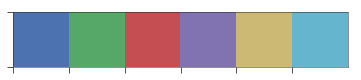

In [53]:
palette = sns.color_palette()
sns.palplot(palette);

In [56]:
#t_hat adjustments
pt_hat_left = (1 + pmuts_left) / (2 * (pspd_left * rr_left + pspd_left_accessible * mu_left))
pt_hat_right = (1 + pmuts_right) / (2 * (pspd_right * rr_right + pspd_right_accessible * mu_right))

In [58]:
pspd_both = pspd_left + pspd_right
pmuts_both = pmuts_left + pmuts_right
psgl_both = pspd_left * rr_left + pspd_right * rr_right
psml_both = pspd_left_accessible * mu_left + pspd_right_accessible * mu_right
pt_hat_both = (1 + pmuts_both) / (2 * (psgl_both + psml_both))

#### dendrogram clustering

In [59]:
def plot_dendrogram(dist, cut_height=1e3, yscale='log', ylim=(10, 1e6), linkage_method='average',
                    n_clusters=14):
    """This function plots a dendrogram using scipy and provides some utilities for annotating clusters."""
    
    z = scipy.cluster.hierarchy.linkage(dist, method=linkage_method)

    fig = plt.figure(figsize=(16, 8), )
    gs = mpl.gridspec.GridSpec(nrows=3, ncols=1, height_ratios=[6, .5, 4], hspace=0)

    ax = fig.add_subplot(gs[0])
    sns.despine(ax=ax, offset=3, bottom=True, top=False)
    r = scipy.cluster.hierarchy.dendrogram(
        z, no_labels=True, count_sort=True, 
        color_threshold=0, 
        above_threshold_color='k',
        ax=ax)
    ax.set_ylim(*ylim)
    ax.set_yscale(yscale)
    # ax.set_ylim(bottom=-1000)
    xmin, xmax = ax.xaxis.get_data_interval()
    xticklabels = np.array(list(range(0, len(df_haplotypes), 200)) + [len(df_haplotypes)])
    xticks = xticklabels / len(df_haplotypes)
    xticks = (xticks * (xmax - xmin)) + xmin
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlabel('Haplotypes')
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('$\hat{t}$', rotation=0, ha='right')

    cluster_palette = sns.color_palette('Set3', n_colors=12)
    if cut_height:
        ax.axhline(cut_height, linestyle='--', color='k')
        # find clusters
        f = scipy.cluster.hierarchy.fcluster(z, cut_height, criterion='distance')
        # compute cluster sizes
        fsz = np.bincount(f)
        # sort largest first
        fsort = np.argsort(fsz)[::-1]
        # take largest n
        fsort = fsort[:n_clusters]
        # get haplotype indices for each cluster
        clusters = [set(np.nonzero(f == i)[0]) for i in fsort]
        clusters_leaves = [sorted([r['leaves'].index(i) for i in cluster])
                           for cluster in clusters]
        ixs = np.argsort([min(cl) for cl in clusters_leaves])
        clusters = [clusters[i] for i in ixs]
        clusters_leaves = [clusters_leaves[i] for i in ixs]
        for i, cluster_leaves in enumerate(clusters_leaves):
            color = cluster_palette[i % len(cluster_palette)]
            x1, x2 = min(cluster_leaves), max(cluster_leaves)
#             ax.axvline(x1*10, color='k', linestyle='--')
#             ax.axvline(x2*10, color='k', linestyle='--')
            ax.fill_between([x1*10, x2*10], 0, cut_height, color=color, alpha=.4, zorder=20)
#             ax.axvspan(x1*10, x2*10, color=color, zorder=-20, alpha=.5)
            ax.text((x1*10 + x2*10) / 2, ylim[0], str(i), ha='center', va='top')
        
    ax = fig.add_subplot(gs[1], )
    sns.despine(ax=ax, left=True, bottom=True)
    pops = df_haplotypes.population[r['leaves']]
    pop_colors = [phase1_ar3.pop_colors[p] for p in pops]
    ax.broken_barh([(i, 1) for i in range(len(df_haplotypes))], yrange=(0, 1), color=pop_colors)
    ax.set_xlim(0, len(df_haplotypes))
    ax.set_yticks([])
    ax.set_ylabel('Population', rotation=0, ha='right', va='center')
    ax.set_xticks([])
    if cut_height:
        for i, cluster_leaves in enumerate(clusters_leaves):
            color = cluster_palette[i % len(cluster_palette)]
            x1, x2 = min(cluster_leaves), max(cluster_leaves)
            ax.axvline(x1, color='k', linestyle='--', zorder=20)
            ax.axvline(x2, color='k', linestyle='--', zorder=20)

    ax = fig.add_subplot(gs[2])
    hapclust.plot_haplotypes(ax, haps_vgsc_missense[:, r['leaves']], lbl_vgsc_missense)
    ax.set_xlim(0, len(df_haplotypes))
    ax.set_xlabel('Haplotypes')
    if cut_height:
        for i, cluster_leaves in enumerate(clusters_leaves):
            color = cluster_palette[i % len(cluster_palette)]
            x1, x2 = min(cluster_leaves), max(cluster_leaves)
            ax.axvline(x1, color='k', linestyle='--', zorder=20)
            ax.axvline(x2, color='k', linestyle='--', zorder=20)
            ax.axvspan(x1, x2, color=color, zorder=20, alpha=.4)

    gs.tight_layout(fig, h_pad=0)
    return clusters

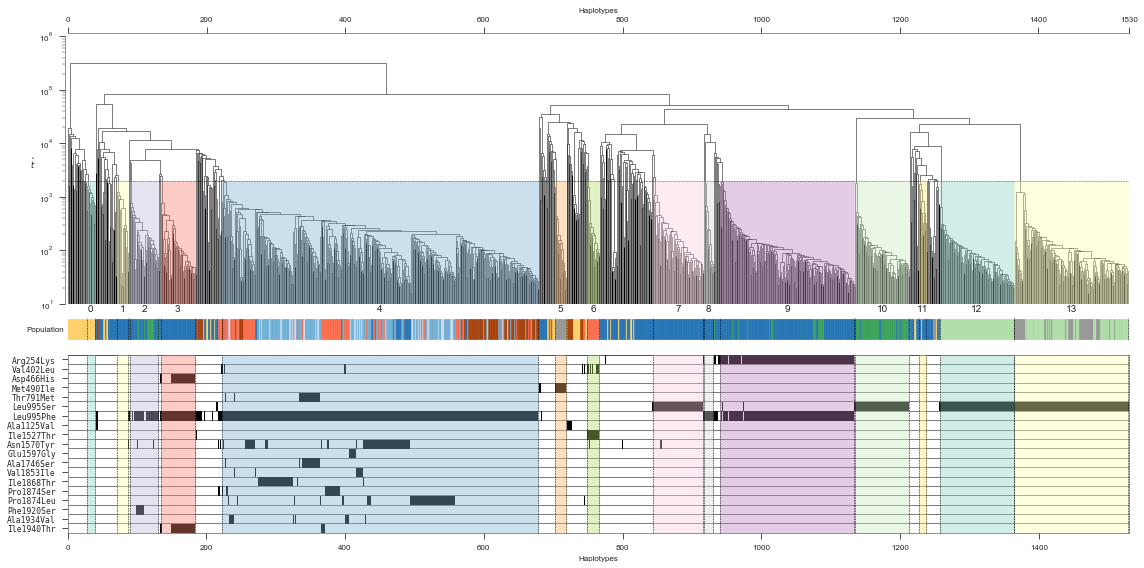

In [60]:
# canonical dendrogram we'll use for cluster analyses
clusters = plot_dendrogram(pt_hat_both, cut_height=2e3)

# age comparison

In [61]:
haps_vgsc_missense

<HaplotypeArray shape=(19, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 2 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 1 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [62]:
[len(c) for c in clusters]

[12, 17, 42, 51, 456, 16, 18, 73, 14, 194, 79, 12, 108, 165]

In [63]:
# pick these out of the clusters we made earlier
f1 = clusters[4]
f2 = clusters[8]
f3 = clusters[3]
f4 = clusters[2]
f5 = clusters[9]
s1 = clusters[12]
s2 = clusters[10]
s3 = clusters[13]
s4 = clusters[7]
l1 = clusters[6]

In [64]:
# rhg = "resistance haplogroups"
rhg = [f1, f2, f3, f4, f5, s1, s2, s3, s4, l1]
rhg_labels = 'F1 F2 F3 F4 F5 S1 S2 S3 S4 L1'.split()

In [65]:
for g, l in zip(rhg, rhg_labels):
    print(l)
    print(collections.Counter(df_haplotypes.population[sorted(g)]).most_common())

F1
[('BFS', 162), ('BFM', 110), ('AOM', 90), ('GNS', 62), ('CMS', 32)]
F2
[('CMS', 14)]
F3
[('CMS', 51)]
F4
[('CMS', 26), ('GAS', 16)]
F5
[('CMS', 170), ('GAS', 24)]
S1
[('UGS', 108)]
S2
[('GAS', 71), ('CMS', 8)]
S3
[('UGS', 98), ('KES', 67)]
S4
[('CMS', 73)]
L1
[('BFM', 18)]


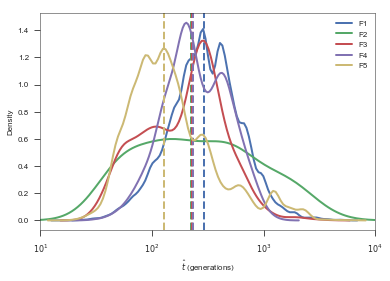

In [66]:
# compare F haplogroups
fig, ax = plt.subplots()
for g, l, cl in zip(rhg[:5], rhg_labels[:5], palette):
    ixs = allel.condensed_coords_within(g, len(df_haplotypes))
    x = np.log10(pt_hat_both[ixs])
    sns.distplot(x, bins=np.linspace(1, 3, 20), label=l, hist=False, 
                 kde_kws=dict(linewidth=2, color=cl))
    ax.axvline(np.median(x), color=cl, linestyle='--', lw=2)
ax.set_ylabel('Density')
ax.set_xlim(1, 4)
ticks = [1, 2, 3, 4]
ax.set_xticks(ticks)
ax.set_xticklabels(['$10^{%s}$' % t for t in ticks])
ax.set_xlabel('$\hat{t}$ (generations)');

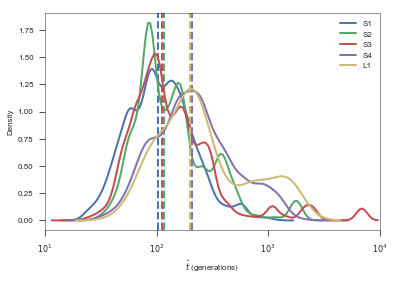

In [71]:
# compare S haplogroups
fig, ax = plt.subplots()
for g, l, cl in zip(rhg[5:], rhg_labels[5:], palette):
    ixs = allel.condensed_coords_within(g, len(df_haplotypes))
    x = np.log10(pt_hat_both[ixs])
    sns.distplot(x, bins=np.linspace(1, 3, 20), label=l, hist=False, 
                 kde_kws=dict(linewidth=2, color=cl))
    ax.axvline(np.median(x), color=cl, linestyle='--', lw=2)
ax.set_ylabel('Density')
ax.set_xlim(1, 4)
ticks = [1, 2, 3, 4]
ax.set_xticks(ticks)
ax.set_xticklabels(['$10^{%s}$' % t for t in ticks])
ax.set_xlabel('$\hat{t}$ (generations)');